In [7]:
%load_ext autoreload
%autoreload 2

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from src.paths import RAW_DATA_DIR, PREPROCESSED_DATA_DIR

sns.set_style('darkgrid')

In [11]:
weather = pd.read_csv(RAW_DATA_DIR / 'weather.csv')

print(f'\n---WEATHER DATA---\nNumber of rows: {weather.shape[0]}\nColumns: {weather.columns.to_list()}\n')

print(f'Number of "M": {(weather=="M").sum().sum()}')


---WEATHER DATA---
Number of rows: 2944
Columns: ['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']

Number of "M": 7415


In [12]:
columns_to_stay = ['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'CodeSum','PrecipTotal']
weather = weather[columns_to_stay]

# look closer at missing values in weather data
missing_weather = pd.DataFrame((weather=='M').sum(), columns=['number'])
missing_weather['percent'] = (missing_weather.number/weather.shape[0]*100).round(1)
missing_weather

,number,percent
Station,0,0.0
Date,0,0.0
Tmax,0,0.0
Tmin,0,0.0
Tavg,11,0.4
DewPoint,0,0.0
WetBulb,4,0.1
CodeSum,0,0.0
PrecipTotal,2,0.1


In [13]:
weather.Tavg = np.where(
    weather.Tavg == 'M',
    weather[['Tmax', 'Tmin']].mean(axis=1),
    weather.Tavg
).astype('int')

weather[weather.WetBulb=='M']

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal
848,1,2009-06-26,86,69,78,60,M,,0.00
2410,1,2013-08-10,81,64,73,57,M,,0.00
2412,1,2013-08-11,81,60,71,61,M,RA,0.01
2415,2,2013-08-12,85,69,77,63,M,RA,0.66


In [16]:
lr = LinearRegression()

train_weather = weather[weather.WetBulb!='M'][['Tmax', 'Tmin', 'DewPoint', 'WetBulb']]
test_weather = weather[weather.WetBulb=='M'][['Tmax', 'Tmin', 'DewPoint']]
y_train = train_weather.pop('WetBulb').astype(float)
X_train = train_weather
X_test = test_weather

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

missing_index = weather[weather.WetBulb=='M'].index
weather.loc[missing_index, 'WetBulb'] = y_pred.round()

weather.WetBulb = weather.WetBulb.astype(float)

weather[weather.PrecipTotal=='M']

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal
117,2,2007-06-28,73,61,67,56,61.0,,M
119,2,2007-06-29,71,56,64,56,60.0,,M


In [17]:
missing_dates = weather[weather.PrecipTotal=='M'].Date
missing_dates
weather[weather.Date.isin(missing_dates)]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal
116,1,2007-06-28,74,58,66,55,60.0,,0.00
117,2,2007-06-28,73,61,67,56,61.0,,M
118,1,2007-06-29,70,56,63,55,59.0,,0.00
119,2,2007-06-29,71,56,64,56,60.0,,M


In [18]:
no_precip1_dates = weather[(weather.PrecipTotal=='0.00')&(weather.Station==1)].Date

weather[
    (weather.Station==2)&
    (weather.Date.isin(no_precip1_dates))&
    (weather.PrecipTotal!='0.00')&
    (weather.CodeSum==' ')&
    (weather.Date.str[-4]=='6')]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal
117,2,2007-06-28,73,61,67,56,61.0,,M
119,2,2007-06-29,71,56,64,56,60.0,,M
1173,2,2010-06-04,83,60,72,59,64.0,,T
1961,2,2012-06-30,89,70,80,68,72.0,,T
2667,2,2014-06-15,86,64,75,58,65.0,,T


In [19]:
weather.drop('CodeSum', axis=1, inplace=True)
weather.PrecipTotal = weather.PrecipTotal.str.strip().str.replace('T', '0.001').str.replace('M', '0.001').astype('float')
weather.Date = pd.to_datetime(weather.Date)
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int64
DewPoint                int64
WetBulb               float64
PrecipTotal           float64
dtype: object

In [20]:
weather_st1 = weather[weather.Station==1].drop('Station', axis=1)
weather_st2 = weather[weather.Station==2].drop('Station', axis=1)
weather = weather_st1.merge(weather_st2, on='Date', suffixes=['_1', '_2'])

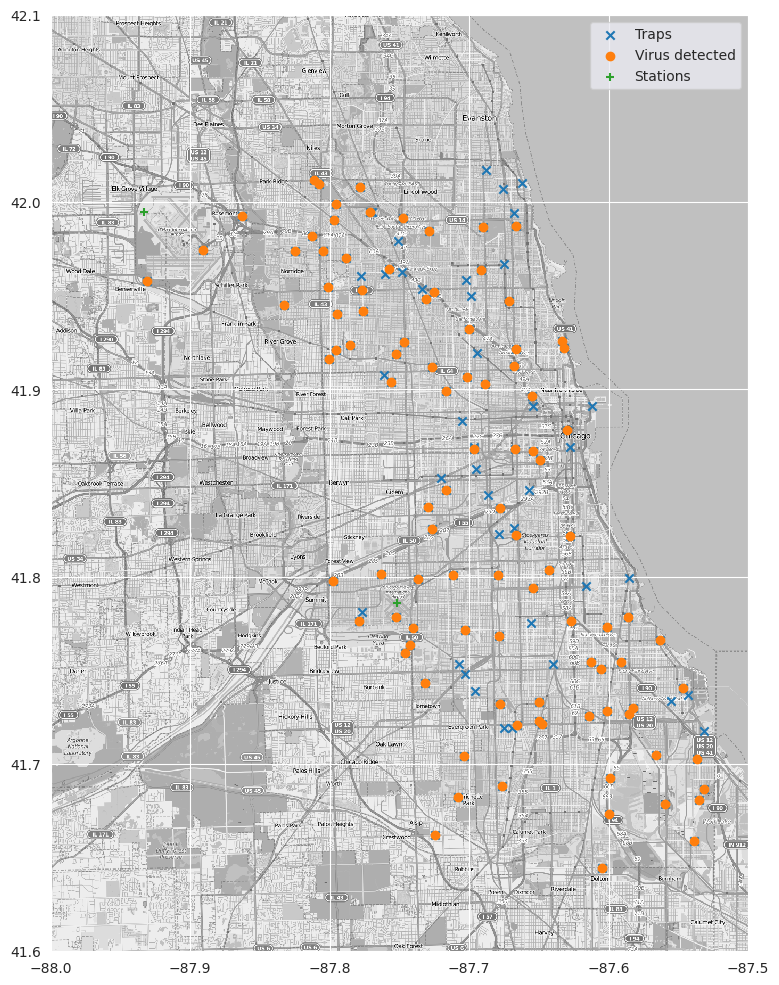

In [22]:
stations = np.array([[-87.933, 41.995],[-87.752, 41.786]])
image_arr = np.loadtxt(RAW_DATA_DIR / 'mapdata_copyright_openstreetmap_contributors.txt')
plt.figure(figsize=(9,13))
plt.imshow(image_arr, interpolation='nearest', cmap='gray', extent=(-88, -87.5, 41.6, 42.1), aspect=image_arr.shape[0]/image_arr.shape[1])
locations = data_train[['Longitude', 'Latitude']].drop_duplicates().values
locations_wnv = data_train[data_train.WnvPresent!=0][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Traps')
plt.scatter(locations_wnv[:,0], locations_wnv[:,1], marker='o', label='Virus detected')
plt.scatter(stations[:,0], stations[:,1], marker='+', label='Stations')
plt.legend()
plt.show()

In [24]:
weather

,Date,Tmax_1,Tmin_1,Tavg_1,DewPoint_1,WetBulb_1,PrecipTotal_1,Tmax_2,Tmin_2,Tavg_2,DewPoint_2,WetBulb_2,PrecipTotal_2
0,2007-05-01,83,50,67,51,56.0,0.000,84,52,68,51,57.0,0.000
1,2007-05-02,59,42,51,42,47.0,0.000,60,43,52,42,47.0,0.000
2,2007-05-03,66,46,56,40,48.0,0.000,67,48,58,40,50.0,0.000
3,2007-05-04,66,49,58,41,50.0,0.001,78,51,64,42,50.0,0.000
4,2007-05-05,66,53,60,38,49.0,0.001,66,54,60,39,50.0,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,77,51,64,51,58.0,0.000,79,54,67,52,59.0,0.020
1468,2014-10-28,68,45,57,38,47.0,0.001,66,48,57,40,48.0,0.030
1469,2014-10-29,49,36,43,32,40.0,0.000,49,40,45,34,42.0,0.000
1470,2014-10-30,51,32,42,34,40.0,0.000,53,37,45,35,42.0,0.001


In [26]:
weather.to_pickle(PREPROCESSED_DATA_DIR / 'clean_weather.pkl')